# FEATURE PRE-SELECTION

This notebook is strictly dedicated to feature selection.

Goal: decide which variables are allowed to pass into the modeling phase, reducing noise, redundancy, and leakage while preserving predictive signal.

- All features are already engineered, encoded, and scaled where appropriate
- The target variable is defined (delay_flag for classification, delay_minutes for regression use cases)
- No new features are created here

This notebook outputs:

- A reduced analytical dataset
- A documented list of selected features

This notebook applies a progressive feature selection strategy.

Feature selection is not treated as a single automatic step, but as a sequence of increasingly strict filters.

- **Mutual Information (MI)** is used as an initial screening tool to remove features with no individual signal. MI is model-agnostic and captures non-linear dependencies but does not account for feature interactions.
- **Recursive Feature Elimination (RFE)** is applied on the MI-selected subset to remove redundant variables and retain features that contribute jointly.
- **Permutation Importance (PI)** is used as a robustness check to verify which features the model actually relies on.

At each stage, a conservative cutoff is applied to preserve interaction effects. Final decisions are deferred to later modeling steps.

Feature selection here is intended to remove obvious noise, not to aggressively minimize the feature set.

## IMPORT LIBRARIES

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

#Autocomplete
%config IPCompleter.greedy=True

## IMPORT DATA

In [7]:
df = pd.read_csv('/Users/rober/smartport-delay-risk-scoring/02_Data/03_Working/work_fe.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116481 entries, 0 to 116480
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   record_id                       116481 non-null  int64  
 1   imo                             116481 non-null  int64  
 2   ship_name                       116481 non-null  object 
 3   lat                             116481 non-null  float64
 4   lon                             116481 non-null  float64
 5   sog                             116481 non-null  float64
 6   cog                             116481 non-null  float64
 7   hdg                             116481 non-null  float64
 8   hour                            116475 non-null  float64
 9   hour_of_day                     116475 non-null  float64
 10  day_of_week                     116475 non-null  float64
 11  time_since_last_position_min    116468 non-null  float64
 12  reporting_interv

## Define target, candidate features and split X and y

In [9]:
target = "delay_flag"

exclude_cols = [
    "record_id",
    "ship_name",
    "imo"
]

X = df.drop(columns=exclude_cols + [target])
y = df[target]

- Identifiers and raw timestamps are excluded

- `delay_minutes` was already removed to avoid leakage

- All remaining columns are candidate predictors

## SUPERVISED METHODS

### Mutual Information (signal detection)

Mutual Information is used as an initial filtering step to measure **how much the target depends on each predictor considered individually** (how much knowing a single feature reduces uncertainty about the target).

It captures non-linear relationships, but it evaluates each feature independently and does not account for interactions or redundancy.

#### Remove rows with NaN values

Mutual Information is a supervised method and **requires a known target value for each observation**.

Rows with missing target values do not provide learning signal and cannot contribute to the dependency estimation, so they must be excluded before computing feature importance.

In [10]:
mask = y.notna() & X.notna().all(axis=1)

X_mi = X.loc[mask]
y_mi = y.loc[mask]

#### Create a function to show the output

In [11]:
def ranking_mi(mutual_selector, mode='table'):
    # Build the ranking table
    ranking_mi = pd.DataFrame(mutual_selector, index=X.columns).reset_index()
    ranking_mi.columns = ['variable', 'mi_importance']
    ranking_mi = ranking_mi.sort_values(by='mi_importance', ascending=False)
    ranking_mi['mi_rank'] = np.arange(0, ranking_mi.shape[0])    
    # Display the output
    if mode == 'table':
        return ranking_mi
    else:
        g = ranking_mi.mi_importance.sort_values().plot.barh(figsize=(10, 10))
        g.set_yticklabels(ranking_mi.sort_values(by='mi_importance').variable)
        return g

#### Calculate and check

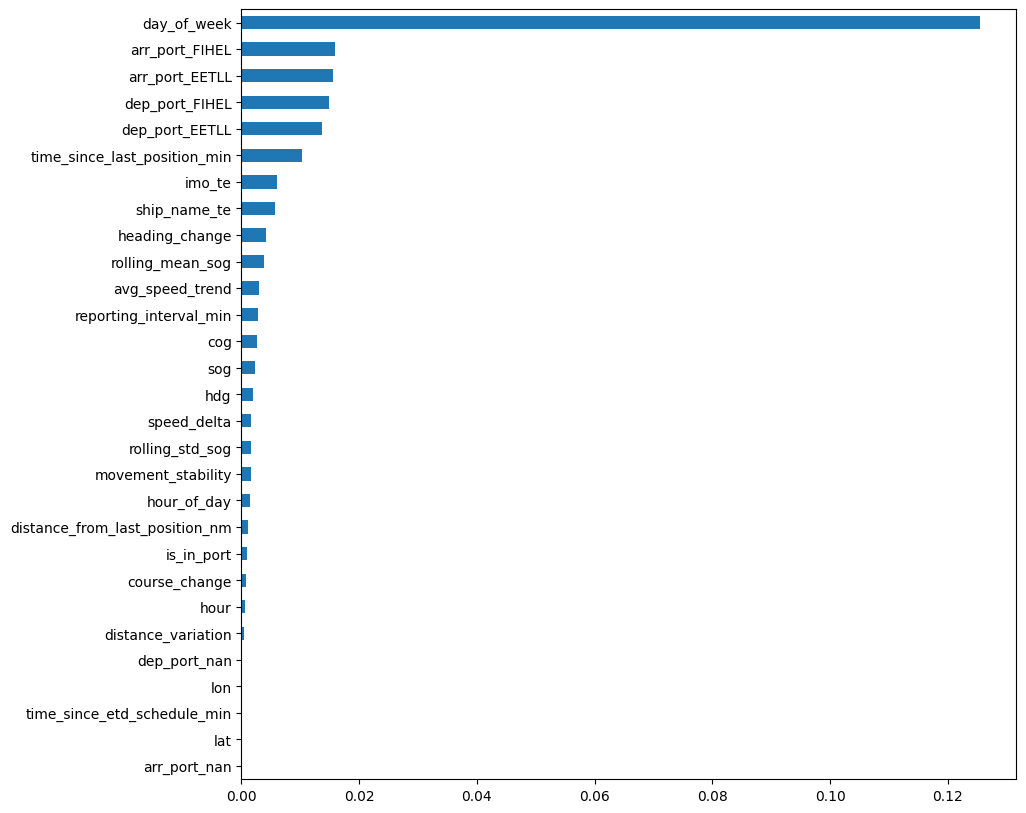

In [12]:
mutual_selector = mutual_info_classif(
    X_mi,
    y_mi,
    random_state=42
)

rank_mi = ranking_mi(mutual_selector, mode="plot")

Although only 2-3 features show strong individual importance in MI, many others become valuable only through interactions.

**We keep the top 19 MI-ranked features** to preserve variables that may only become predictive through interactions. Tree-based models rely on such interactions, so MI is used as a prioritization tool rather than an aggressive elimination step.

Mutual Information cannot detect these combined patterns, while tree-based models can. 

Therefore, we keep a broader set of top-ranked MI features at this stage and let later supervised methods (RFE, permutation importance) determine which ones truly contribute.

#### Select top N features

##### Position of the last feature

In [13]:
position_limit_feature = 19

##### Extract names of selected variables

In [14]:
include_mi = ranking_mi(mutual_selector).iloc[0:position_limit_feature].variable

##### Create dataframe with selected variables

In [15]:
X_mi = X[include_mi].copy()

### Recursive Feature Elimination (redundancy removal)

Mutual Information provides a conservative preselection of features with individual signal, but it does not account for redundancy between variables.

At this stage, RFE is used to remove redundant features within the MI-selected subset by evaluating features jointly using a simple, stable model.

The objective of RFE here is not to find an optimal feature count, but to perform a light pruning step that reduces collinearity while preserving interaction potential.

The number of retained features (15) is chosen conservatively:

- MI previously selected a broader set (e.g. 18 features)
- RFE removes only a small number to reduce redundancy

The goal is to avoid aggressive elimination at this stage

This ensures that potentially useful features are not discarded prematurely.
Final relevance is evaluated later using model-based importance measures.

**Logistic Regression** is used in RFE because it provides stable, interpretable coefficients and a clear notion of marginal contribution, which makes it suitable for redundancy pruning. RFE requires a simple, deterministic model to rank features consistently.

More complex models (e.g. XGBoost) capture interactions and non-linearities, which makes feature rankings unstable and harder to interpret in a recursive elimination setting. Those models are better suited for final modeling, not for intermediate feature pruning.

In [17]:
# 1. Ensure X and y are perfectly aligned
# We use the index to make sure they have the exact same rows
common_index = X_mi.index.intersection(y_mi.index)
X_aligned = X_mi.loc[common_index]
y_aligned = y_mi.loc[common_index]

# 2. Remove any remaining NaNs across both
mask_rfe = X_aligned.notna().all(axis=1) & y_aligned.notna()
X_rfe = X_aligned.loc[mask_rfe]
y_rfe = y_aligned.loc[mask_rfe]

# 3. Run the RFE
base_model = LogisticRegression(max_iter=1000, solver="liblinear")
rfe = RFE(estimator=base_model, n_features_to_select=15)

rfe.fit(X_rfe, y_rfe)
print(f"✔ RFE complete. Samples processed: {len(X_rfe)}")

✔ RFE complete. Samples processed: 116464


#### Extract RFE-selected features

In [18]:
rfe_features = [
    col
    for col, keep in zip(X_rfe.columns, rfe.support_)
    if keep
]

#### Reduce X_rfe

In [19]:
X_rfe = X_rfe[rfe_features]

### Permutation Importance

Permutation Importance measures how much each feature impacts prediction performance by randomly shuffling its values and observing the drop in ROC AUC. 

Features that cause a large performance drop are important to the model. 

This method is model-agnostic and complements RFE by validating which features are genuinely useful in the final model behavior.

Permutation Importance answers this question:
“Does the trained model actually rely on this feature to make predictions?”

Method:
1. Train a model on the selected features
2. Randomly shuffle one feature at a time
3. Measure how much model performance drops

nterpretation:
- Positive importance = model depends on this feature
- Zero importance = feature is ignored
- Negative importance = feature adds noise

Why we use it here:
- MI checks individual signal
- RFE removes redundancy
- PI validates real usage by a predictive model

PI is the last filter before modeling.

In [20]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_rfe, y_rfe)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
perm = permutation_importance(
    rf,
    X_rfe,
    y_rfe,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

In [22]:
rank_per = (
    pd.DataFrame({
        "variable": X_rfe.columns,
        "importance_per": perm.importances_mean
    })
    .sort_values(by="importance_per", ascending=False)
    .reset_index(drop=True)
)

In [23]:
# FINAL SUPERVISED RULE:
# Only variables with positive contribution survive
final_features = rank_per[rank_per.importance_per > 0].variable.tolist()

In [24]:
X_final = X_rfe[final_features]

## NON SUPERVISED METHODS

### Correlation

In [25]:
def drop_high_corr(X, threshold=0.9):
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop = [c for c in upper.columns if any(upper[c] > threshold)]
    return X.drop(columns=drop), drop

In [26]:
X_final, dropped_corr = drop_high_corr(X_final, threshold=0.9)

## FINAL OUTPUT

In [27]:
df_final = df[X_final.columns.tolist() + ["delay_flag"]]

df_final.to_csv(
    '/Users/rober/smartport-delay-risk-scoring/02_Data/03_Working/work_fs.csv',
    index=False
)

In [28]:
df_final

,day_of_week,rolling_mean_sog,hdg,movement_stability,cog,speed_delta,heading_change,imo_te,reporting_interval_min,time_since_last_position_min,dep_port_FIHEL,delay_flag
0,0.666667,0.167638,0.679666,1.000000,0.186111,NaN,NaN,1.000000,NaN,NaN,0.0,1.0
1,0.666667,0.163994,0.596100,1.000000,0.086111,NaN,NaN,0.719043,NaN,NaN,0.0,1.0
2,0.666667,0.047376,0.582173,1.000000,0.580556,NaN,NaN,0.756725,NaN,NaN,1.0,1.0
3,0.666667,0.185860,0.640669,0.572978,0.125000,0.520661,0.462396,1.000000,0.001001,0.832573,0.0,1.0
4,0.666667,0.183431,0.665738,0.565550,0.100000,0.485537,0.526462,1.000000,0.000956,0.832566,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
116476,1.000000,0.387026,0.498607,0.107650,0.602778,0.390496,0.738162,0.756725,0.000933,0.832568,0.0,0.0
116477,1.000000,0.607143,0.582173,0.118642,0.583333,0.409091,0.621170,0.719043,0.000956,0.832569,1.0,0.0
116478,1.000000,0.274781,0.537604,0.103205,0.802778,0.481405,0.540390,0.756725,0.000933,0.832566,0.0,0.0
116479,1.000000,0.503644,0.601671,0.107584,0.600000,0.477273,0.520891,0.719043,0.000956,0.832568,1.0,0.0


In [29]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116481 entries, 0 to 116480
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   day_of_week                   116475 non-null  float64
 1   rolling_mean_sog              116481 non-null  float64
 2   hdg                           116481 non-null  float64
 3   movement_stability            116481 non-null  float64
 4   cog                           116481 non-null  float64
 5   speed_delta                   116477 non-null  float64
 6   heading_change                116477 non-null  float64
 7   imo_te                        116481 non-null  float64
 8   reporting_interval_min        116474 non-null  float64
 9   time_since_last_position_min  116468 non-null  float64
 10  dep_port_FIHEL                116481 non-null  float64
 11  delay_flag                    116481 non-null  float64
dtypes: float64(12)
memory usage: 10.7 MB
